Install packages - rdkit will take ~15+ minutes to install

In [1]:
pip install Mordred

Processing /home/jovyan/.cache/pip/wheels/02/c0/2e/e7e3d63b431777712ebc128bc4deb9ac5cb19afc7c1ea341ec/mordred-1.2.0-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [2]:
%%time
conda install rdkit

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.7.12
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base conda


Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.7.12
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - rdkit


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    binutils_impl_linux-64-2.35.1|       h17ad2fc_0         9.3 MB  conda-forge
    binutils_linux-64-2.35     |      hc3fd857_29          22 KB  conda-forge
    boost-1.72.0               |   py37h

# Chemical Descriptors
Chemical descriptors essentially break a molecule down into numerical values so they can be treated quantitatively to build models for various applications$.^{[1]}$ <br/>
<center><em>"The molecular descriptor is the final result of a logic and mathematical procedure which transforms chemical information encoded within a symbolic representation of a molecule into a useful number or the result of some standardized experiment$"^{[2]}$</em> ~ Roberto Todeschini </center>
<br>
Chemical descriptors can be split up into different dimensions$:^{[3]}$ <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - 0D: bond counts, molecular weight, atom count<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - 1D: fragment count, acceptor-donor bonds<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - 2D: topological properties, connectivity<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - 3D: geometric properties, charged partial surface area<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - 4D: coordinates + conformations <br>

We will be focusing on dimensions 0-2.



Import all packages and modules

In [3]:
from mordred import Calculator, descriptors
import pandas as pd
import numpy as np
from rdkit import Chem
import re

Read csv into pandas dataframe and take a look at the pandas structure

In [4]:
df = pd.read_csv("week9data.csv")
df.shape

(2500, 18)

In [5]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'HOMO', 'LUMO', 'GAP', 'R2', 'ZPVE', 'U0',
       'U', 'H', 'G', 'Cv', 'vibrational_frequencies', 'E1', 'E2', 'f1', 'f2',
       'smiles'],
      dtype='object')

In [6]:
df.head()

,Unnamed: 0,Unnamed: 0.1,HOMO,LUMO,GAP,R2,ZPVE,U0,U,H,G,Cv,vibrational_frequencies,E1,E2,f1,f2,smiles
0,10000,10000,-0.2818,0.0280,0.3097,1109.2219,0.163679,-365.089448,-365.079822,-365.078877,-365.123724,34.380,"[77.0073, 93.2123, 138.9224, 178.5504, 192.620...",0.286147,0.307326,0.010474,0.007055,CCC(C#N)C(C)O
1,10001,10001,-0.2338,0.0329,0.2667,1089.3310,0.175667,-345.190043,-345.180226,-345.179282,-345.224536,34.754,"[68.1297, 104.648, 134.4941, 165.5848, 199.264...",0.235913,0.261144,0.001335,0.042259,CCC(C#N)N(C)C
2,10002,10002,-0.2355,0.0301,0.2656,1055.7727,0.165093,-361.232458,-361.222832,-361.221888,-361.266686,34.109,"[69.584, 118.7058, 134.3934, 165.618, 220.7816...",0.239750,0.254295,0.001491,0.008953,CN(C)C(CN)C#N
3,10003,10003,-0.2497,0.0220,0.2716,1013.7067,0.152666,-381.108212,-381.099011,-381.098067,-381.142312,32.682,"[45.8503, 102.8705, 159.4111, 190.3544, 225.52...",0.244233,0.268198,0.031047,0.029736,CN(C)C(CO)C#N
4,10004,10004,-0.2468,0.0315,0.2783,1158.4078,0.175927,-345.197890,-345.188039,-345.187095,-345.232383,35.096,"[66.8466, 103.8318, 149.7294, 188.3125, 197.93...",0.243494,0.273211,0.005493,0.006682,CNC(C#N)C(C)C


# RDKit

Build a list of SMILES from the csv file and use rdkit to translate the string to format Mordred can read

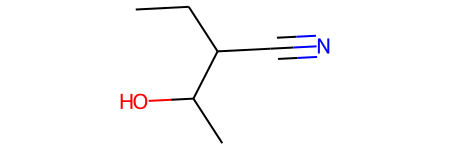

In [7]:
SMILES = []
for molecule in df["smiles"]:
    SMILES.append(Chem.MolFromSmiles(molecule))
SMILES[0]

# Mordred

Specific descriptors can be calculated by calling the appropriate module from the Mordred package

In [8]:
mol_id = descriptors.MolecularId.MolecularId() # molecular ID
nAtoms = descriptors.AtomCount.AtomCount() # number of all atoms  
abci = descriptors.ABCIndex.ABCGGIndex() # atom-bond connectivity index
aromatic = descriptors.Aromatic.AromaticAtomsCount() # aromatic atoms count
nARing = descriptors.RingCount.RingCount(None, False, False, True, None) # aromatic ring count
nFARing = descriptors.RingCount.RingCount(None, False, True, True, None) # aromatic fused ring count
frag_cplx = descriptors.FragmentComplexity.FragmentComplexity() # fragment complexity
dist_matrix = descriptors.DistanceMatrix.DistanceMatrix("SpAbs") # graph energy from distance matrix

Mordred descriptor list reference:    
http://mordred-descriptor.github.io/documentation/master/descriptors.html

Let's do some calculations on a random molecule from our SMILES list

In [9]:
mol = SMILES[0]

In [10]:
print(nAtoms(mol))
print(aromatic(mol))
print(frag_cplx(mol))
print(dist_matrix(mol))

19
0
7.02
34.83747069060095


### Exercise 1:
Using the link above, load in other models and calculate new descriptors

In [50]:
nH = descriptors.AtomCount.AtomCount('H')
C1SP2 = descriptors.CarbonTypes.CarbonTypes(1,2) #sp2 carbon bound to 1 other carbon 
nRot = descriptors.RotatableBond.RotatableBondsCount()
MW = descriptors.Weight.Weight(True, False)

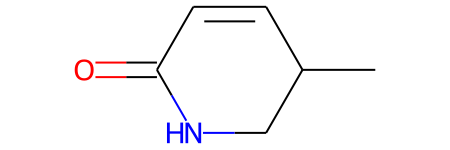

In [57]:
mol = SMILES[500]
SMILES[500]

In [58]:
print("Number of Hydrogen Molecules: " +str(nH(mol)))
print("Number of Rotatable Bonsd: " + str(nRot(mol)))
print("Number of SP2 Carbons bound to 1 other carbon: " + str(C1SP2(mol)))
print("Molecular Weight: " + str(MW(mol)))

Number of Hydrogen Molecules: 9
Number of Rotatable Bonsd: 0
Number of SP2 Carbons bound to 1 other carbon: 1
Molecular Weight: 111.068413908


### Exercise 2:
Build an np.array containing the following descriptors for molecules 1236, 1358, 1468, 1569, and 1896 in our SMILES list:
1. The number of O atoms
2. Balaban's J index
3. 3rd ordered Chi weighted by valence electrons
4. Atomic polarizability
5. Topoligical polar surface area

In [79]:
nO = descriptors.AtomCount.AtomCount('O')
BalabanJ = descriptors.BalabanJ.BalabanJ()
Xch3d = descriptors.Chi.Chi('chain', 3, 'd', False)
apol = descriptors.Polarizability.APol(False)
TopoPSA = descriptors.TopoPSA.TopoPSA(False)

mol1 = SMILES[1236]
mol2 = SMILES[1358]
mol3 = SMILES[1468]
mol4 = SMILES[1569]
mol5 = SMILES[1896]

np.array([
         [nO(mol1), nO(mol2), nO(mol3), nO(mol4), nO(mol5)],
         [BalabanJ(mol1), BalabanJ(mol2), BalabanJ(mol3), BalabanJ(mol4), BalabanJ(mol5)],
         [Xch3d(mol1), Xch3d(mol2), Xch3d(mol3), Xch3d(mol4), Xch3d(mol5)],
         [apol(mol1), apol(mol2), apol(mol3), apol(mol4), apol(mol5)],
         [TopoPSA(mol1), TopoPSA(mol2), TopoPSA(mol3), TopoPSA(mol4), TopoPSA(mol5)]
        ])

array([[ 2.        ,  1.        ,  2.        ,  2.        ,  2.        ],
       [ 1.98189019,  2.077935  ,  2.08878651,  2.02758335,  2.24934812],
       [ 0.28867513,  0.        ,  0.        ,  0.25      ,  0.        ],
       [17.055137  , 19.256723  , 16.958344  , 15.721551  , 15.721551  ],
       [52.32      , 12.47      , 29.46      , 38.33      , 37.38      ]])

Initiate calculator to calculate ALL descriptors

In [60]:
calc = Calculator(descriptors)
len(calc.descriptors)
#calc.descriptors[0]

1826

Calculate ALL descriptors for SMILES in list

In [61]:
mordred_df = calc.pandas(SMILES)

100%|██████████| 2500/2500 [01:41<00:00, 24.65it/s]


In [62]:
mordred_df.shape
mordred_df.head()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,5.128087,5.749949,0,0,8.720566,2.101003,4.202006,8.720566,1.090071,2.90085,...,8.124151,34.544698,113.084064,5.951793,67,8,30.0,31.0,4.722222,2.111111
1,5.128087,5.749949,0,1,8.720566,2.101003,4.202006,8.720566,1.090071,2.90085,...,8.124151,34.544698,112.100048,5.605002,67,8,30.0,31.0,4.722222,2.111111
2,5.128087,5.749949,0,2,8.720566,2.101003,4.202006,8.720566,1.090071,2.90085,...,8.124151,34.544698,113.095297,5.952384,67,8,30.0,31.0,4.722222,2.111111
3,5.128087,5.749949,0,1,8.720566,2.101003,4.202006,8.720566,1.090071,2.90085,...,8.124151,34.544698,114.079313,6.337740,67,8,30.0,31.0,4.722222,2.111111
4,5.128087,5.749949,0,1,8.720566,2.101003,4.202006,8.720566,1.090071,2.90085,...,8.124151,34.544698,112.100048,5.605002,67,8,30.0,31.0,4.722222,2.111111


In [63]:
final_df = pd.concat([df, mordred_df], axis=1)
final_df.head()

,Unnamed: 0,Unnamed: 0.1,HOMO,LUMO,GAP,R2,ZPVE,U0,U,H,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,10000,10000,-0.2818,0.0280,0.3097,1109.2219,0.163679,-365.089448,-365.079822,-365.078877,...,8.124151,34.544698,113.084064,5.951793,67,8,30.0,31.0,4.722222,2.111111
1,10001,10001,-0.2338,0.0329,0.2667,1089.3310,0.175667,-345.190043,-345.180226,-345.179282,...,8.124151,34.544698,112.100048,5.605002,67,8,30.0,31.0,4.722222,2.111111
2,10002,10002,-0.2355,0.0301,0.2656,1055.7727,0.165093,-361.232458,-361.222832,-361.221888,...,8.124151,34.544698,113.095297,5.952384,67,8,30.0,31.0,4.722222,2.111111
3,10003,10003,-0.2497,0.0220,0.2716,1013.7067,0.152666,-381.108212,-381.099011,-381.098067,...,8.124151,34.544698,114.079313,6.337740,67,8,30.0,31.0,4.722222,2.111111
4,10004,10004,-0.2468,0.0315,0.2783,1158.4078,0.175927,-345.197890,-345.188039,-345.187095,...,8.124151,34.544698,112.100048,5.605002,67,8,30.0,31.0,4.722222,2.111111


#### Save dataframe as csv

In [64]:
final_df.to_csv("mordred_df.csv")

# References:
1. https://jcheminf.biomedcentral.com/articles/10.1186/s13321-018-0258-y <br/>
2. https://onlinelibrary.wiley.com/doi/pdf/10.1002/9783527613106.fmatter <br/>
3. https://fiehnlab.ucdavis.edu/staff/kind/chemoinformatics/concepts/descriptors <br/>